# Exploratoty Data Analysis

In [4]:
import pandas as pd

data = pd.read_csv("./data/column_3C_weka.csv")
data_X = data.drop("class", axis=1)
data_y = data["class"]

In [9]:
data["class"].value_counts()

class
Spondylolisthesis    150
Normal               100
Hernia                60
Name: count, dtype: int64

Some classes are not balanced, so they will be balanced with oversample

In [14]:
### oversampling for imbalanced data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
data_X_sampled, data_y_sampled = smote.fit_resample(data_X, data_y)

In [18]:
data_y_sampled.value_counts()

class
Hernia               150
Spondylolisthesis    150
Normal               150
Name: count, dtype: int64

After the oversample, all classes are balanced

In [19]:
### search for null values
data_X_sampled.isnull().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
dtype: int64

In [20]:
data_y_sampled.isnull().sum()

np.int64(0)

No null values finded

In [21]:
### search for duplicated values
data_X_sampled.duplicated().sum()

np.int64(0)

No duplicates finded

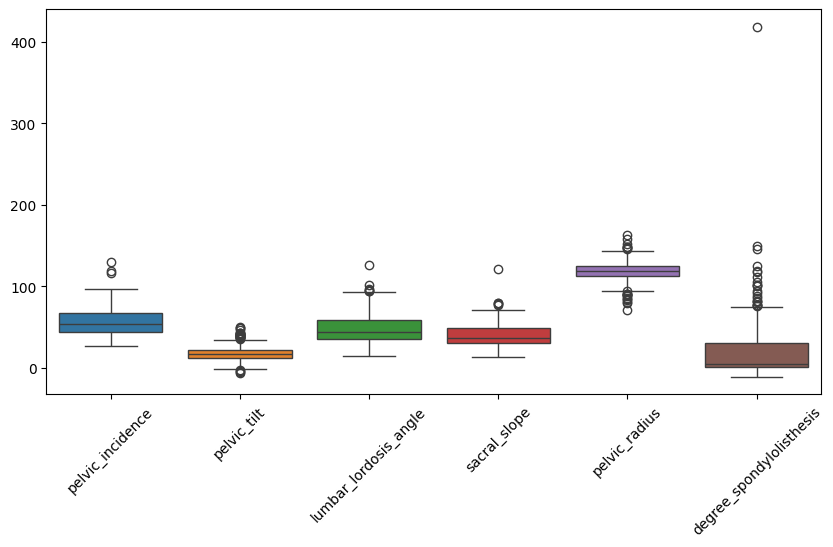

In [26]:
### seach for outliers

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(data=data_X_sampled)
plt.xticks(rotation=45)
plt.show()

The outliers wont be removed, since we are dealing with real data and it could be a rare case patient

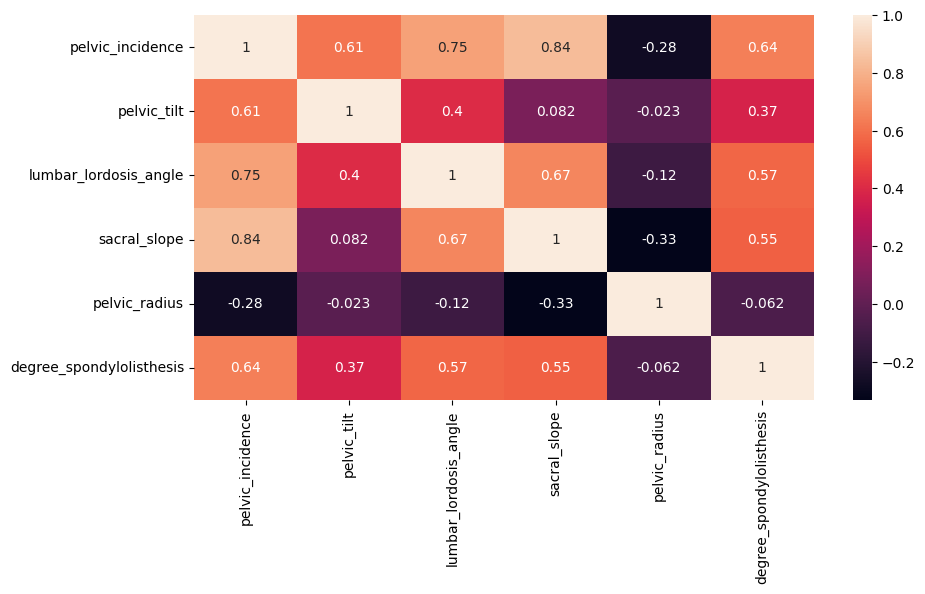

In [29]:
### see the correlation between features
plt.figure(figsize=(10, 5))
sns.heatmap(data_X_sampled.corr(), annot=True)
plt.xticks(rotation=45)
plt.show()

In [30]:
### remove features with high correlation
data_X_sampled = data_X_sampled.drop(["pelvic_incidence"], axis=1)

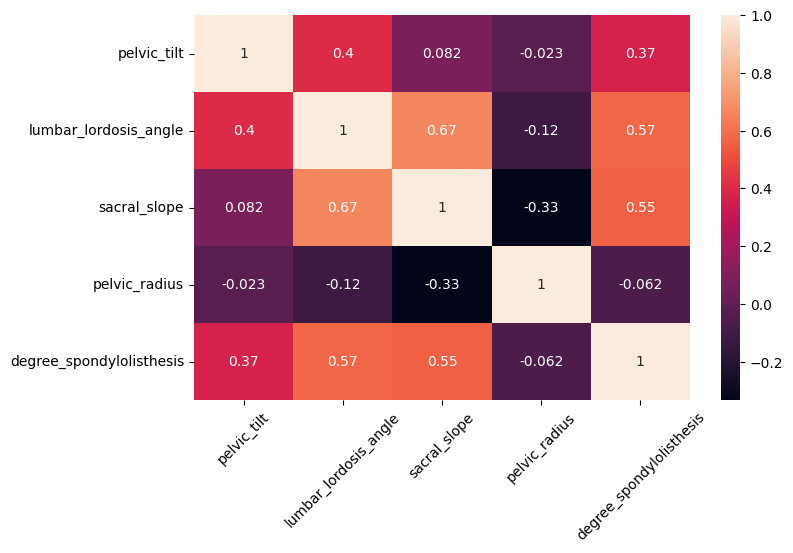

In [33]:
### see correlation again
plt.figure(figsize=(8, 5))
sns.heatmap(data_X_sampled.corr(), annot=True)
plt.xticks(rotation=45)
plt.show()

In [65]:
### split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X_sampled, data_y_sampled, test_size=0.25, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(337, 5)
(337,)
(113, 5)
(113,)


In [66]:
### save the data
X_train.to_csv("./data/X_train.csv", index=False)
X_test.to_csv("./data/X_test.csv", index=False)
y_train.to_csv("./data/y_train.csv", index=False)
y_test.to_csv("./data/y_test.csv", index=False)

# Model training
With Random Forest

In [67]:
# label encoding the target variable

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [40]:
### save the label encoder
import joblib

joblib.dump(le, "./model/label_encoder.pkl")

['./model/label_encoder.pkl']

In [52]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

def objective(trial):
    # Sugerindo valores de hiperparâmetros
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2', None])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    model.fit(X_train, y_train)

    recall = recall_score(y_test, model.predict(X_test), average="weighted")

    return recall

In [53]:
### run the optimization

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-09-25 14:57:33,709] A new study created in memory with name: no-name-b46f045e-bab6-4cbd-8f08-69b39f2d0a18
[I 2024-09-25 14:57:33,890] Trial 0 finished with value: 0.8495575221238938 and parameters: {'n_estimators': 237, 'max_depth': 29, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.8495575221238938.
[I 2024-09-25 14:57:34,040] Trial 1 finished with value: 0.8584070796460177 and parameters: {'n_estimators': 190, 'max_depth': 29, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.8584070796460177.
[I 2024-09-25 14:57:34,154] Trial 2 finished with value: 0.8495575221238938 and parameters: {'n_estimators': 190, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.8584070796460177.
[I 2024-09-25 14:57:34,221] Trial 3 finished with value: 0.8672566371681416 

In [54]:
### create the model with the best hyperparameters

best_params = study.best_params

model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"], 
    max_depth=best_params["max_depth"], 
    max_features=best_params["max_features"], 
    random_state=42
)

model

RandomForestClassifier(max_depth=11, max_features='log2', n_estimators=99,
                       random_state=42)

In [68]:
model.fit(X_train, y_train)

joblib.dump(model, "./model/rf_model.pkl")

['./model/rf_model.pkl']

In [79]:
### evaluate the model
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# unlabel encoding
y_test_label = le.inverse_transform(y_test)
y_pred_label = le.inverse_transform(y_pred)

classification = classification_report(y_test, y_pred)
print(classification_report(y_test_label, y_pred_label))

                   precision    recall  f1-score   support

           Hernia       0.78      0.89      0.83        44
           Normal       0.81      0.64      0.71        33
Spondylolisthesis       0.97      1.00      0.99        36

         accuracy                           0.85       113
        macro avg       0.85      0.84      0.84       113
     weighted avg       0.85      0.85      0.85       113



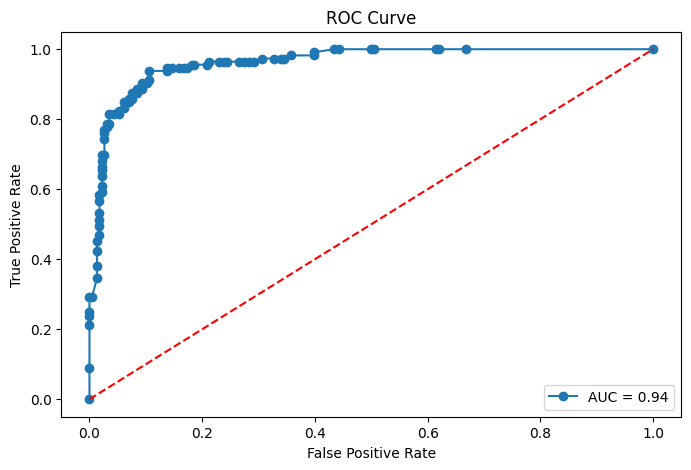

In [76]:
### auc roc curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_label, classes=le.classes_)
y_pred_proba_bin = model.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba_bin.ravel())
roc_auc = roc_auc_score(y_test_bin, y_pred_proba_bin)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, marker="o", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve")
plt.show()

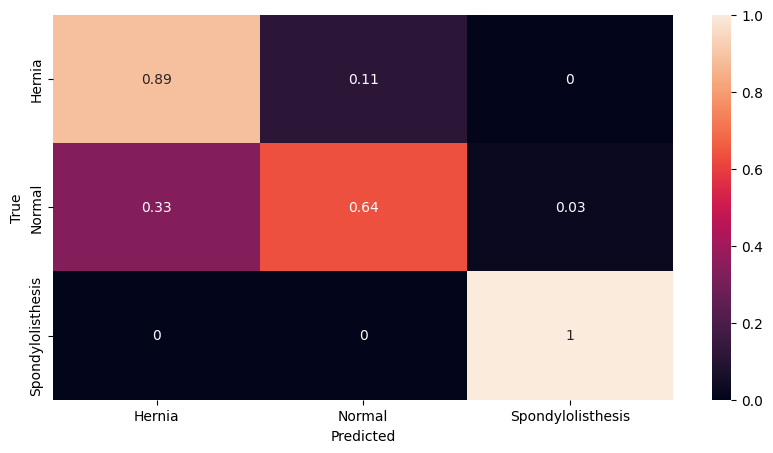

In [61]:
### plot percentage confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True)
plt.xticks(ticks=np.arange(3) + 0.5, labels=le.classes_)
plt.yticks(ticks=np.arange(3) + 0.5, labels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [97]:
precision = classification_report(y_test_label, y_pred_label, output_dict=True)["weighted avg"]["precision"]
recall = classification_report(y_test_label, y_pred_label, output_dict=True)["weighted avg"]["recall"]
f1 = classification_report(y_test_label, y_pred_label, output_dict=True)["weighted avg"]["f1-score"]

# Criar o DataFrame de classificação
classification_df = pd.DataFrame({
    "precision": [f"{precision:.4f}"],
    "recall": [f"{recall:.4f}"],
    "f1": [f"{f1:.4f}"],
    "fpr": [f"{fpr.mean():.4f}"],
    "tpr": [f"{tpr.mean():.4f}"],
    "auc": [f"{roc_auc:.4f}"]
})

classification_df


,precision,recall,f1,fpr,tpr,auc
0,0.8496,0.8496,0.8452,0.1573,0.7725,0.9446
